In [1]:
import pandas
import datetime
import numpy
import scipy.optimize
from scipy.optimize import curve_fit
from scipy.stats import linregress
import seaborn as sns
import matplotlib.pyplot as plt
import os
import time
import bs4
import urllib
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
%matplotlib inline

In [2]:
# Some constants
cutOffMLTMLATUniqCnt = 4

In [3]:
velsDataDF = pandas.read_csv( "../data/processed-vels-geomag-fin.txt", sep=' ',\
                            infer_datetime_format=True,\
                            parse_dates=["date"])
# Get actual SAPS azimuths
velsDataDF["azim"] = -90.-velsDataDF["azim"]
velsDataDF.head()

,azim,azimStd,delMLT,goodFit,MLAT,normMLT,vSaps,velSTD,endPtMLAT,endPtNormMLT,...,dst_index,dst_bin,datetimeStr,AE,AL,AO,AU,count,maxCount,probOcc
0,-79.412573,1.794202,0.5,True,62.0,-6.0,306.738497,11.198685,62.06,-6.30,...,-44.0,"(-50, -25]",20121014-01-00,500,-343,-93,157,470,2562,0.18345
1,-76.475692,1.486233,1.0,True,62.0,-6.0,301.958739,8.617099,62.07,-6.29,...,-44.0,"(-50, -25]",20121014-01-02,490,-341,-96,149,470,2562,0.18345
2,-78.295769,1.771100,0.5,True,62.0,-6.0,328.832509,13.365574,62.07,-6.32,...,-44.0,"(-50, -25]",20121014-01-04,527,-371,-108,156,470,2562,0.18345
3,-78.597362,1.525368,1.0,True,62.0,-6.0,357.951508,12.264929,62.07,-6.35,...,-44.0,"(-50, -25]",20121014-01-06,515,-366,-109,149,470,2562,0.18345
4,-78.413884,1.070948,1.0,True,62.0,-6.0,406.549966,10.616775,62.08,-6.40,...,-44.0,"(-50, -25]",20121014-01-08,527,-373,-110,154,470,2562,0.18345


In [4]:
# Filter out some values
# When there aren't good number of measurements at lats
# discard those values
cntMLTPntsDF = velsDataDF[ ["dst_bin", "normMLT", "MLAT"] \
                    ].groupby( ["dst_bin", "normMLT"] \
                    )["MLAT"].nunique().reset_index()
cntMLTPntsDF.columns = ["dst_bin", "normMLT", "MLATCntUnq"]
cntMLTPntsDF = cntMLTPntsDF[ cntMLTPntsDF["MLATCntUnq"] >=\
                    cutOffMLTMLATUniqCnt ][ ["dst_bin", "normMLT"]\
                        ].reset_index(drop=True)
velsDataDF = pandas.merge( velsDataDF, cntMLTPntsDF,\
                    on=["dst_bin", "normMLT"], how="inner" )

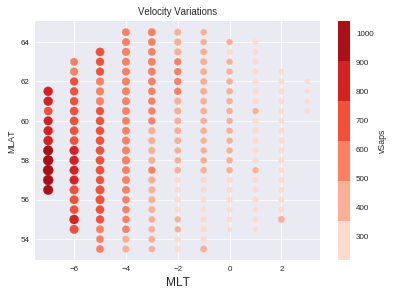

In [5]:
# We'll now divide data into MLT/MLAT bins and get some stats
mltMlatMeanDF = velsDataDF.groupby( [ "normMLT", "MLAT" ] ).mean().reset_index()
# Seaborn styling
sns.set_style("darkgrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("Reds"))
# Plot using matplotlib
fig1 = plt.figure()
ax = fig1.add_subplot(111)
mltMlatMeanDF.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=mltMlatMeanDF["vSaps"]/10, cmap=seaMap, ax=ax)
ax.set_ylabel("MLAT")
ax.set_xlabel("MLT", fontsize=12)
ax.set_title( "Velocity Variations" )
plt.savefig("../figs/meanVelMLATMLT.pdf",bbox_inches='tight')

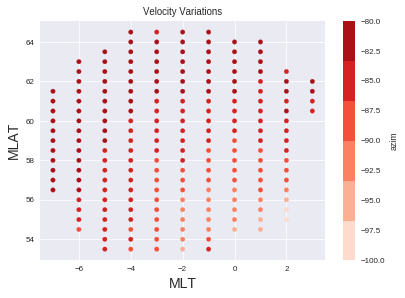

In [6]:
mltMlatMeanDF = velsDataDF[ velsDataDF["goodFit"] ].groupby( [ "normMLT", "MLAT" ] ).mean().reset_index()
# Seaborn styling
sns.set_style("darkgrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("Reds"))

# Plot using matplotlib
fig1 = plt.figure()
ax = fig1.add_subplot(111)
mltMlatMeanDF.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='azim',
              s=20, cmap=seaMap, ax=ax, vmin=-100, vmax=-80)
ax.set_ylabel("MLAT", fontsize=14)
ax.set_xlabel("MLT", fontsize=14)
ax.set_title( "Velocity Variations" )
plt.savefig("../figs/meanAzimMLATMLT.pdf",bbox_inches='tight')

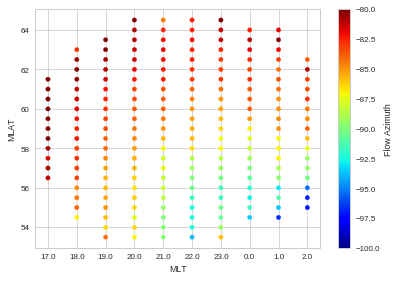

In [7]:
mltMlatMeanDF = velsDataDF[ (velsDataDF["normMLT"] < 3.) &\
                          (velsDataDF["goodFit"])].groupby( [ "normMLT", "MLAT" ] ).mean().reset_index()
unqNrmMLTList = sorted( mltMlatMeanDF["normMLT"].unique().tolist() )
mltMlatMeanDF["Flow Azimuth"] = mltMlatMeanDF["azim"]
mltStr = []
for j in unqNrmMLTList:
    if j < 0:
        mltStr.append( str(j + 24) )
    else:
        mltStr.append( str(j) )
# Seaborn styling
sns.set_style("whitegrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("Reds"))

myColors = ((0.8, 0.0, 0.0, 1.0), (0.0, 0.8, 0.0, 1.0), (0.0, 0.0, 0.8, 1.0))
cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))


# Plot using matplotlib
fig1 = plt.figure()
ax = fig1.add_subplot(111)
mltMlatMeanDF.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='Flow Azimuth',
              s=20, cmap=plt.cm.get_cmap("jet"), ax=ax, vmin=-100, vmax=-80)

plt.xlabel( "MLT" )
plt.xticks(unqNrmMLTList, mltStr, size='small')        

plt.savefig("../figs/meanAzimMLATMLT-dir.pdf",bbox_inches='tight')

In [8]:
# GET Mean and Std of Azims vs MLT and MLAT!
azimMLTMeanDF = mltMlatMeanDF[[ "normMLT", "azim" ]].groupby( [ "normMLT" ] ).mean().reset_index()
azimMLTMeanDF.columns = [ "normMLT", "azim_est_mlt_mean" ]
azimMLTStdDF = mltMlatMeanDF[[ "normMLT", "azim" ]].groupby( [ "normMLT" ] ).std().reset_index()
azimMLTStdDF.columns = [ "normMLT", "azim_est_mlt_std" ]
azimMLTMeanDF = pandas.merge( azimMLTMeanDF, azimMLTStdDF, on=[ "normMLT" ] )
# GET MLAT MEAN/STD
azimMLATMeanDF = mltMlatMeanDF[[ "MLAT", "azim" ]].groupby( [ "MLAT" ] ).mean().reset_index()
azimMLATMeanDF.columns = [ "MLAT", "azim_est_mlat_mean" ]
azimMLATStdDF = mltMlatMeanDF[[ "MLAT", "azim" ]].groupby( [ "MLAT" ] ).std().reset_index()
azimMLATStdDF.columns = [ "MLAT", "azim_est_mlat_std" ]
azimMLATMeanDF = pandas.merge( azimMLATMeanDF, azimMLATStdDF, on=[ "MLAT" ] )


# We'll fit Azim as a linear function of MLT and Dst
def azim_fit_func((magCrd), a_azim, b_azim):
    # func
    azim = a_azim + b_azim*(magCrd)
    return azim.ravel()

initGuess = ( 1, 1 )
poptMLT, pcovMLT = curve_fit(azim_fit_func, (azimMLTMeanDF['normMLT'].T),\
                         azimMLTMeanDF['azim_est_mlt_mean'], p0=( 1, 1 ))   
poptMLAT, pcovMLAT = curve_fit(azim_fit_func, (azimMLATMeanDF['MLAT'].T),\
                         azimMLATMeanDF['azim_est_mlat_mean'], p0=( 1, 1 ))   
print poptMLT
print "-----------"
print poptMLAT
( a_azimMLT, b_azimMLT ) = tuple( poptMLT.tolist() )
( a_azimMLAT, b_azimMLAT ) = tuple( poptMLAT.tolist() )

azimMLTMeanDF["azim_pred"] = a_azimMLT + b_azimMLT*(azimMLTMeanDF['normMLT'])

azimMLATMeanDF["azim_pred"] = a_azimMLAT + b_azimMLAT*(azimMLATMeanDF['MLAT'])

strVelAzimPredMLT = "SAPS Azim = " + str( round( a_azimMLT,1 ) ) + " + (" + str( round( b_azimMLT,1 ) )  + ") x $\Delta MLT_{00}$"
strVelAzimPredMLAT = "SAPS Azim = " + str( round( a_azimMLAT,1 ) ) + " + (" + str( round( b_azimMLAT,1 ) )  + ") x MLAT"


[-86.71895138  -0.73257604]
-----------
[-138.07723253    0.89760661]


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


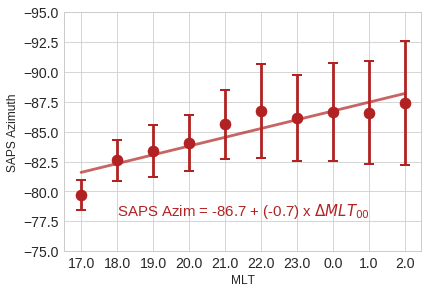

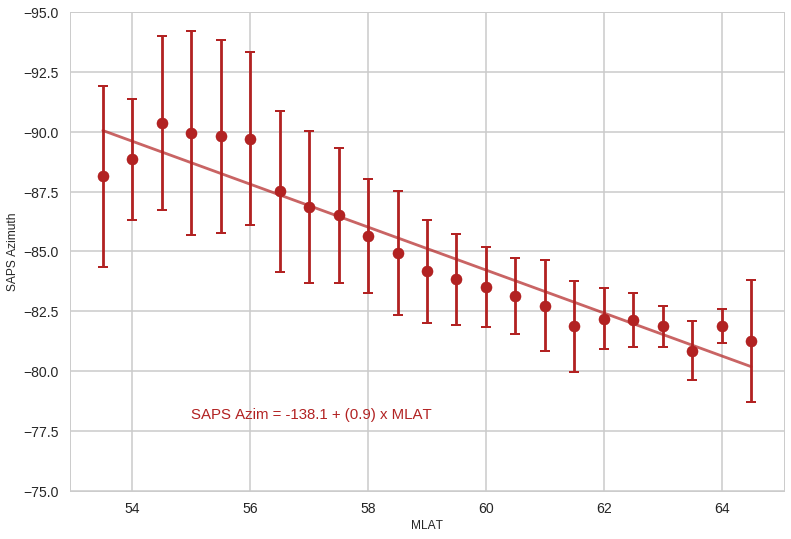

In [9]:
unqNrmMLTList = sorted( azimMLTMeanDF[ (azimMLTMeanDF["normMLT"] < 3.) ]["normMLT"].unique().tolist() )
mltStr = []
for j in unqNrmMLTList:
    if j < 0:
        mltStr.append( str(j + 24) )
    else:
        mltStr.append( str(j) )
# setup fig
fig = plt.figure()
ax1 = fig.add_subplot(111)
# seaborn styling
sns.set_style("whitegrid")
sns.set_context("poster")



azimMLTMeanDF = azimMLTMeanDF.sort(["normMLT"])
azimMLTMeanDF = azimMLTMeanDF[ azimMLTMeanDF["normMLT"] < 3. ]
ax1.scatter(azimMLTMeanDF['normMLT'],
            azimMLTMeanDF['azim_est_mlt_mean'],
            marker='o',
            color='firebrick',
            alpha=0.7,
            s = 124)

ax1.plot(azimMLTMeanDF['normMLT'],
            azimMLTMeanDF['azim_pred'] ,
            color='firebrick',
            alpha=0.7)

ax1.errorbar(azimMLTMeanDF['normMLT'],\
             azimMLTMeanDF['azim_est_mlt_mean'],\
             yerr=azimMLTMeanDF['azim_est_mlt_std'], fmt='o',\
             color='firebrick', label='', capthick=2., capsize=5.)
ax1.set_xlabel("MLT", fontsize=12)
ax1.set_ylabel("SAPS Azimuth", fontsize=12)
plt.xlabel( "MLT" )
plt.xticks(unqNrmMLTList, mltStr, size='small') 
plt.tick_params(labelsize=14)
ax1.set_ylim( [-75,-95] )

plt.text(-6., -78., strVelAzimPredMLT, fontsize=15, color='firebrick')

plt.savefig("../figs/meanStdMLTAzim.pdf",bbox_inches='tight')

# PLOT MLAT MEAN STDs
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(azimMLATMeanDF['MLAT'],
            azimMLATMeanDF['azim_est_mlat_mean'],
            marker='o',
            color='firebrick',
            alpha=0.7,
            s = 124)

ax1.plot(azimMLATMeanDF['MLAT'],
            azimMLATMeanDF['azim_pred'] ,
            color='firebrick',
            alpha=0.7)

ax1.errorbar(azimMLATMeanDF['MLAT'],\
             azimMLATMeanDF['azim_est_mlat_mean'],\
             yerr=azimMLATMeanDF['azim_est_mlat_std'], fmt='o', \
             color='firebrick', label='', capthick=2., capsize=5.)


ax1.set_xlabel("MLAT", fontsize=12)
ax1.set_ylabel("SAPS Azimuth", fontsize=12)
plt.tick_params(labelsize=14)
ax1.set_ylim( [-75,-95] )

plt.text(55., -78., strVelAzimPredMLAT, fontsize=15, color='firebrick')

plt.savefig("../figs/meanStdMLATAzim.pdf",bbox_inches='tight')

In [10]:
# Groupby Dst bin
dstLocDF = velsDataDF.groupby( [ "dst_bin", "normMLT", "MLAT" ] ).median().reset_index()
dstLocDF.head()

,dst_bin,normMLT,MLAT,azim,azimStd,delMLT,goodFit,vSaps,velSTD,endPtMLAT,...,hour,minute,dst_index,AE,AL,AO,AU,count,maxCount,probOcc
0,"(-10, 10]",-3.0,59.5,-82.051821,2.379968,1.0,True,350.939275,15.592388,59.545,...,6.0,33.0,-7.0,390.5,-210.0,-12.0,181.0,124.0,759.0,0.163373
1,"(-10, 10]",-3.0,60.0,-82.085134,1.372198,1.0,True,357.243000,12.414065,60.050,...,6.0,32.0,-7.0,388.0,-210.0,-15.0,178.0,227.0,759.0,0.299078
2,"(-10, 10]",-3.0,60.5,-82.420550,1.536634,1.5,True,398.334875,14.742123,60.560,...,6.0,30.0,-7.0,390.5,-218.0,-15.0,171.0,238.0,759.0,0.313570
3,"(-10, 10]",-3.0,61.0,-81.831595,1.802198,1.5,True,436.351116,22.276968,61.060,...,6.0,32.0,-7.0,383.0,-209.0,-16.0,157.0,318.0,759.0,0.418972
4,"(-10, 10]",-3.0,61.5,-81.471748,1.642800,1.5,True,494.013060,25.380904,61.580,...,6.0,28.0,-7.0,369.0,-197.0,-13.0,154.0,309.0,759.0,0.407115


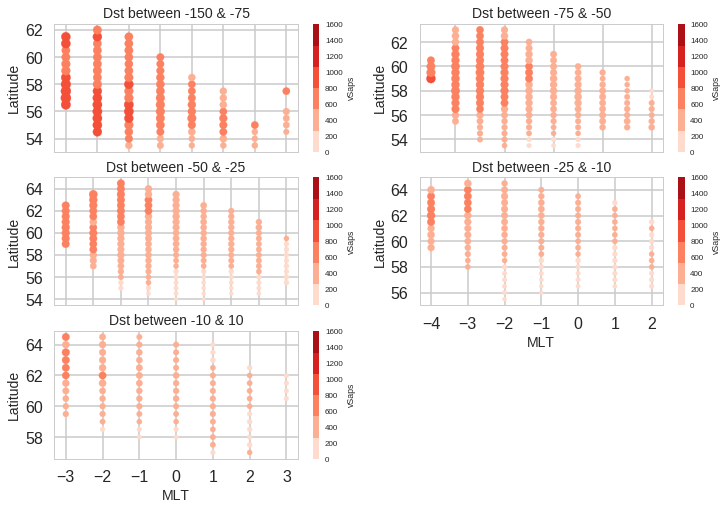

In [11]:
# Make a comparison plot of the data
# for prob of occ at diff locs
# Set up the matplotlib figure
f = plt.figure(figsize=(12, 8))
ax1 = f.add_subplot(3,2,1)
ax2 = f.add_subplot(3,2,2)
ax3 = f.add_subplot(3,2,3)
ax4 = f.add_subplot(3,2,4)
ax5 = f.add_subplot(3,2,5)

velMax = 1600.
velMin = 0.

sns.set_style("darkgrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("Reds"))
# (-150,-75]
dstSapsMLTLat15075 = dstLocDF[ dstLocDF["dst_bin"] == "(-150, -75]" ]
dstSapsMLTLat15075.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=dstSapsMLTLat15075["vSaps"]/10, cmap=seaMap, vmin=velMin, vmax=velMax, ax=ax1, sharex=True)
ax1.set_xlabel("MLT", fontsize=14)
ax1.set_ylabel("Latitude", fontsize=14)
ax1.set_title( "Dst between -150 & -75", fontsize=14 )
# (-75, -50]
dstSapsMLTLat7550 = dstLocDF[ dstLocDF["dst_bin"] == "(-75, -50]" ]
dstSapsMLTLat7550.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=dstSapsMLTLat7550["vSaps"]/10, cmap=seaMap, vmin=velMin, vmax=velMax, ax=ax2)
ax2.set_xlabel("MLT", fontsize=14)
ax2.set_ylabel("Latitude", fontsize=14)
ax2.set_title( "Dst between -75 & -50", fontsize=14 )
# (-50, -25]
dstSapsMLTLat5025 = dstLocDF[ dstLocDF["dst_bin"] == "(-50, -25]" ]
dstSapsMLTLat5025.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=dstSapsMLTLat5025["vSaps"]/10, cmap=seaMap, vmin=velMin, vmax=velMax, ax=ax3)
ax3.set_xlabel("MLT", fontsize=14)
ax3.set_ylabel("Latitude", fontsize=14)
ax3.set_title( "Dst between -50 & -25", fontsize=14 )
# (-25, -10]
dstSapsMLTLat2510 = dstLocDF[ dstLocDF["dst_bin"] == "(-25, -10]" ]
dstSapsMLTLat2510.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=dstSapsMLTLat2510["vSaps"]/10, cmap=seaMap, vmin=velMin, vmax=velMax, ax=ax4)
ax4.set_xlabel("MLT", fontsize=14)
ax4.set_ylabel("Latitude", fontsize=14)
ax4.set_title( "Dst between -25 & -10", fontsize=14 )
# (-10, 10]
dstSapsMLTLat1010 = dstLocDF[ dstLocDF["dst_bin"] == "(-10, 10]" ]
dstSapsMLTLat1010.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=dstSapsMLTLat1010["vSaps"]/10, cmap=seaMap, vmin=velMin, vmax=velMax, ax=ax5)
ax5.set_xlabel("MLT", fontsize=14)
ax5.set_ylabel("Latitude", fontsize=14)
ax5.set_title( "Dst between -10 & 10", fontsize=14 )
plt.savefig("../figs/allDstBinsVels.pdf",bbox_inches='tight')

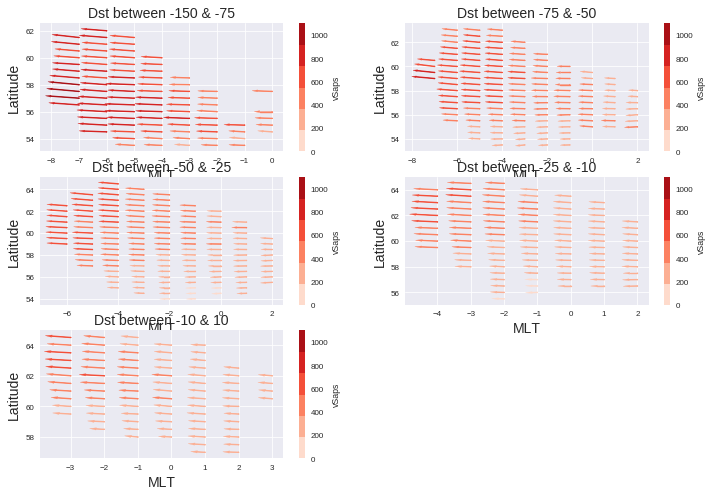

In [12]:
f = plt.figure(figsize=(12, 8))
ax1 = f.add_subplot(3,2,1)
ax2 = f.add_subplot(3,2,2)
ax3 = f.add_subplot(3,2,3)
ax4 = f.add_subplot(3,2,4)
ax5 = f.add_subplot(3,2,5)

# Now setup a velocity scale
velScaleMin = 0.
# round off max velocity to the next hundred
velScaleMax = (dstLocDF["vSaps"].max() + 100.)*100/100\
    - (dstLocDF["vSaps"].max() + 100.)%100

# Seaborn styling
sns.set_style("darkgrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("Reds"))

fitResultsDF15075 = dstLocDF[ dstLocDF["dst_bin"] == "(-150, -75]" ]     
fitResultsDF15075.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=1., cmap=seaMap, vmin=velScaleMin, vmax=velScaleMax, ax=ax1)
ax1.set_xlabel("MLT", fontsize=14)
ax1.set_ylabel("Latitude", fontsize=14)
ax1.set_title( "Dst between -150 & -75", fontsize=14 )

plotMLTends = fitResultsDF15075['endPtNormMLT'].tolist()
plotMLATends = fitResultsDF15075['endPtMLAT'].tolist()
plotMLTbegins = fitResultsDF15075['normMLT'].tolist()
plotMLATbegins = fitResultsDF15075['MLAT'].tolist()
plotVelMagns = fitResultsDF15075['vSaps'].tolist()
# Normalize velocities according to colorbar
colNorm = Normalize( vmin=velScaleMin, vmax=velScaleMax )
for currMLTend, currMLATend, currMLTbgn, currMLATbgn, currVel in\
        zip( plotMLTends, plotMLATends, plotMLTbegins, plotMLATbegins, plotVelMagns ) :
        # get a appropriate color for each bar
        currCol = seaMap( colNorm(currVel) )
        ax1.plot( [currMLTbgn, currMLTend], [ currMLATbgn, currMLATend ], color=currCol )        
        ax1.arrow( currMLTbgn, currMLATbgn, currMLTend-currMLTbgn, currMLATend-currMLATbgn,\
                 head_width=0.15, head_length=0.2, fc=currCol, ec=currCol)
        
        

fitResultsDF7550 = dstLocDF[ dstLocDF["dst_bin"] == "(-75, -50]" ]     
fitResultsDF7550.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=1., cmap=seaMap, vmin=velScaleMin, vmax=velScaleMax, ax=ax2)

plotMLTends = fitResultsDF7550['endPtNormMLT'].tolist()
plotMLATends = fitResultsDF7550['endPtMLAT'].tolist()
plotMLTbegins = fitResultsDF7550['normMLT'].tolist()
plotMLATbegins = fitResultsDF7550['MLAT'].tolist()
plotVelMagns = fitResultsDF7550['vSaps'].tolist()
# Normalize velocities according to colorbar
colNorm = Normalize( vmin=velScaleMin, vmax=velScaleMax )
for currMLTend, currMLATend, currMLTbgn, currMLATbgn, currVel in\
        zip( plotMLTends, plotMLATends, plotMLTbegins, plotMLATbegins, plotVelMagns ) :
        # get a appropriate color for each bar
        currCol = seaMap( colNorm(currVel) )
        ax2.plot( [currMLTbgn, currMLTend], [ currMLATbgn, currMLATend ], color=currCol )        
        ax2.arrow( currMLTbgn, currMLATbgn, currMLTend-currMLTbgn, currMLATend-currMLATbgn,\
                 head_width=0.15, head_length=0.2, fc=currCol, ec=currCol)
        
ax2.set_xlabel("MLT", fontsize=14)
ax2.set_ylabel("Latitude", fontsize=14)
ax2.set_title( "Dst between -75 & -50", fontsize=14 )


fitResultsDF5025 = dstLocDF[ dstLocDF["dst_bin"] == "(-50, -25]" ]     
fitResultsDF5025.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=1., cmap=seaMap, vmin=velScaleMin, vmax=velScaleMax, ax=ax3)

plotMLTends = fitResultsDF5025['endPtNormMLT'].tolist()
plotMLATends = fitResultsDF5025['endPtMLAT'].tolist()
plotMLTbegins = fitResultsDF5025['normMLT'].tolist()
plotMLATbegins = fitResultsDF5025['MLAT'].tolist()
plotVelMagns = fitResultsDF5025['vSaps'].tolist()
# Normalize velocities according to colorbar
colNorm = Normalize( vmin=velScaleMin, vmax=velScaleMax )
for currMLTend, currMLATend, currMLTbgn, currMLATbgn, currVel in\
        zip( plotMLTends, plotMLATends, plotMLTbegins, plotMLATbegins, plotVelMagns ) :
        # get a appropriate color for each bar
        currCol = seaMap( colNorm(currVel) )
        ax3.plot( [currMLTbgn, currMLTend], [ currMLATbgn, currMLATend ], color=currCol )        
        ax3.arrow( currMLTbgn, currMLATbgn, currMLTend-currMLTbgn, currMLATend-currMLATbgn,\
                 head_width=0.15, head_length=0.2, fc=currCol, ec=currCol)
        
ax3.set_xlabel("MLT", fontsize=14)
ax3.set_ylabel("Latitude", fontsize=14)
ax3.set_title( "Dst between -50 & -25", fontsize=14 )


        
        
fitResultsDF2510 = dstLocDF[ dstLocDF["dst_bin"] == "(-25, -10]" ]     
fitResultsDF2510.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=1., cmap=seaMap, vmin=velScaleMin, vmax=velScaleMax, ax=ax4)

plotMLTends = fitResultsDF2510['endPtNormMLT'].tolist()
plotMLATends = fitResultsDF2510['endPtMLAT'].tolist()
plotMLTbegins = fitResultsDF2510['normMLT'].tolist()
plotMLATbegins = fitResultsDF2510['MLAT'].tolist()
plotVelMagns = fitResultsDF2510['vSaps'].tolist()
# Normalize velocities according to colorbar
colNorm = Normalize( vmin=velScaleMin, vmax=velScaleMax )
for currMLTend, currMLATend, currMLTbgn, currMLATbgn, currVel in\
        zip( plotMLTends, plotMLATends, plotMLTbegins, plotMLATbegins, plotVelMagns ) :
        # get a appropriate color for each bar
        currCol = seaMap( colNorm(currVel) )
        ax4.plot( [currMLTbgn, currMLTend], [ currMLATbgn, currMLATend ], color=currCol )        
        ax4.arrow( currMLTbgn, currMLATbgn, currMLTend-currMLTbgn, currMLATend-currMLATbgn,\
                 head_width=0.15, head_length=0.2, fc=currCol, ec=currCol)
        

ax4.set_xlabel("MLT", fontsize=14)
ax4.set_ylabel("Latitude", fontsize=14)
ax4.set_title( "Dst between -25 & -10", fontsize=14 )        
        
        
fitResultsDF1010 = dstLocDF[ dstLocDF["dst_bin"] == "(-10, 10]" ]     
fitResultsDF1010.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=1., cmap=seaMap, vmin=velScaleMin, vmax=velScaleMax, ax=ax5)

plotMLTends = fitResultsDF1010['endPtNormMLT'].tolist()
plotMLATends = fitResultsDF1010['endPtMLAT'].tolist()
plotMLTbegins = fitResultsDF1010['normMLT'].tolist()
plotMLATbegins = fitResultsDF1010['MLAT'].tolist()
plotVelMagns = fitResultsDF1010['vSaps'].tolist()
# Normalize velocities according to colorbar
colNorm = Normalize( vmin=velScaleMin, vmax=velScaleMax )
for currMLTend, currMLATend, currMLTbgn, currMLATbgn, currVel in\
        zip( plotMLTends, plotMLATends, plotMLTbegins, plotMLATbegins, plotVelMagns ) :
        # get a appropriate color for each bar
        currCol = seaMap( colNorm(currVel) )
        ax5.plot( [currMLTbgn, currMLTend], [ currMLATbgn, currMLATend ], color=currCol )        
        ax5.arrow( currMLTbgn, currMLATbgn, currMLTend-currMLTbgn, currMLATend-currMLATbgn,\
                 head_width=0.15, head_length=0.2, fc=currCol, ec=currCol)
ax5.set_xlabel("MLT", fontsize=14)
ax5.set_ylabel("Latitude", fontsize=14)
ax5.set_title( "Dst between -10 & 10", fontsize=14 )
plt.savefig("../figs/allDstBinsVelVecs.pdf",bbox_inches='tight')

In [13]:
# Not only velocity magnitudes we'd also 
# like to plot azimuths!
# get the end points of vectors
dstLocDF["plot_MLATEnd"] = numpy.round( (dstLocDF["vSaps"]/1000.) *\
                                numpy.cos( numpy.deg2rad(-90-1*dstLocDF["azim"]) ) +\
                                dstLocDF["MLAT"], 2)
dstLocDF["plot_normMLTEnd"] = numpy.round( (dstLocDF["vSaps"]/1000.) *\
                                numpy.sin( numpy.deg2rad(-90-1*dstLocDF["azim"]) ) +\
                                dstLocDF["normMLT"], 2)
# Store the data in a file to be used with IDL
# Calculate the median dst in each dst bin
dstBinMedians = velsDataDF.groupby(["dst_bin"]).median().reset_index()
dstBinMedians = dstBinMedians[ [ "dst_bin", "dst_index" ] ]
dstBinMedians.columns = [ "dst_bin", "dst_median" ]
dstBinMedians.head()
sapsVelstoCsv = dstLocDF[ [ "dst_bin", "normMLT", "MLAT",\
                            "vSaps", "azim", "plot_MLATEnd", "plot_normMLTEnd" ] ]
sapsVelstoCsv = pandas.merge( sapsVelstoCsv, dstBinMedians, on=["dst_bin"] )
sapsVelstoCsv["vSaps"] = sapsVelstoCsv["vSaps"].map( lambda x: round(x,2) )
sapsVelstoCsv["azim"] = sapsVelstoCsv["azim"].map( lambda x: round(x,2) )
sapsVelstoCsv = sapsVelstoCsv[ [ "normMLT", "MLAT",\
                            "vSaps", "azim", "plot_MLATEnd", "plot_normMLTEnd", "dst_median" ] ]
sapsVelstoCsv.to_csv("../data/sapsVelsMagnAzimDst.txt", sep=' ', index=False, header=False)

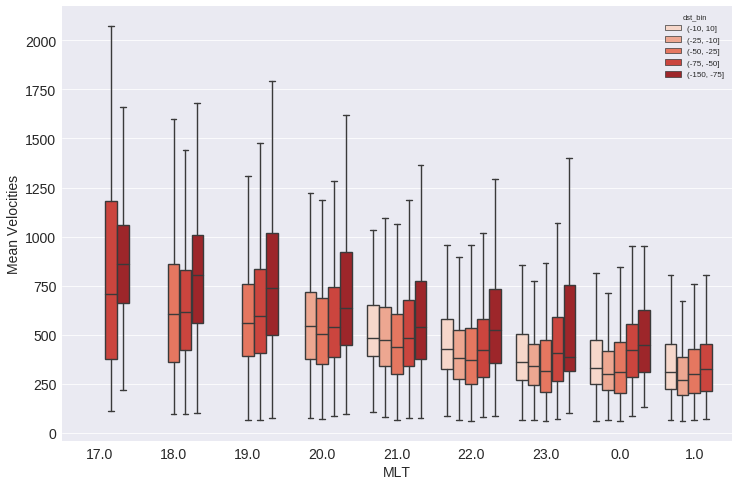

In [14]:
# We need to plot MLTs (we are using normMLT now)
# 
unqNrmMLTList = sorted( velsDataDF[ (velsDataDF["normMLT"] < 2.) ]["normMLT"].unique().tolist() )
mltStr = []
for j in unqNrmMLTList:
    if j < 0:
        mltStr.append( str(j + 24) )
    else:
        mltStr.append( str(j) )

f = plt.figure(figsize=(12, 8))
ax1 = f.add_subplot(1,1,1)
dst_order = [ '(-10, 10]', '(-25, -10]', '(-50, -25]', '(-75, -50]', '(-150, -75]' ]
sns.boxplot( x="normMLT", y="vSaps", hue="dst_bin", data=velsDataDF[ (velsDataDF["normMLT"] < 2.) ],\
            hue_order=dst_order, palette="Reds", showfliers=False )

# plt.xticks( range(len(unqNrmMLTList)), mltStr )
ax1.set_xticklabels( mltStr )
ax1.tick_params(labelsize=14)
ax1.set_xlabel("MLT", fontsize=14)
ax1.set_ylabel("Mean Velocities", fontsize=14)
plt.savefig("../figs/Dst-MLT-Vels.pdf",bbox_inches='tight')

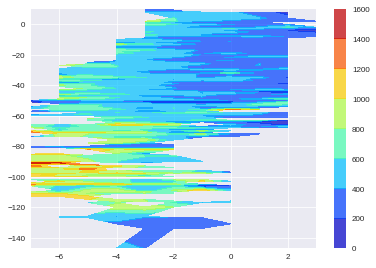

In [15]:
mltDstIndVelDF = velsDataDF[ ["dst_index", "normMLT",\
                    "vSaps"] ].groupby( ["dst_index", "normMLT"]\
                                    ).mean()
velPivot = mltDstIndVelDF.reset_index().pivot( "dst_index", "normMLT" )
X=velPivot.columns.levels[1].values
Y=velPivot.index.values
Z=velPivot.values
Xi,Yi = numpy.meshgrid(X, Y)
plt.contourf(Xi, Yi, Z, alpha=0.7, cmap=plt.cm.jet)
plt.colorbar()

In [16]:
# Work with AE bins
# Create AE bins
aeBins = [ 0, 500, 1000, 2000 ]
velsDataDF = pandas.concat( [ velsDataDF, \
                    pandas.cut( velsDataDF["AE"], \
                               bins=aeBins ) ], axis=1 )
velsDataDF.columns = ['azim', 'azimStd', 'delMLT',\
                      'goodFit', 'MLAT', 'normMLT',\
                      'vSaps', 'velSTD', 'endPtMLAT',\
                      'endPtNormMLT', 'date', 'dtStr',\
                      'hour', 'minute', 'dst_date',\
                      'dst_index', 'dst_bin', 'datetimeStr',\
                      'AE', 'AL', 'AO', 'AU', 'count',\
                      'maxCount', 'probOcc', 'AE_bin']
velsDataDF.head()

,azim,azimStd,delMLT,goodFit,MLAT,normMLT,vSaps,velSTD,endPtMLAT,endPtNormMLT,...,dst_bin,datetimeStr,AE,AL,AO,AU,count,maxCount,probOcc,AE_bin
0,-79.412573,1.794202,0.5,True,62.0,-6.0,306.738497,11.198685,62.06,-6.30,...,"(-50, -25]",20121014-01-00,500,-343,-93,157,470,2562,0.18345,"(0, 500]"
1,-76.475692,1.486233,1.0,True,62.0,-6.0,301.958739,8.617099,62.07,-6.29,...,"(-50, -25]",20121014-01-02,490,-341,-96,149,470,2562,0.18345,"(0, 500]"
2,-78.295769,1.771100,0.5,True,62.0,-6.0,328.832509,13.365574,62.07,-6.32,...,"(-50, -25]",20121014-01-04,527,-371,-108,156,470,2562,0.18345,"(500, 1000]"
3,-78.597362,1.525368,1.0,True,62.0,-6.0,357.951508,12.264929,62.07,-6.35,...,"(-50, -25]",20121014-01-06,515,-366,-109,149,470,2562,0.18345,"(500, 1000]"
4,-78.413884,1.070948,1.0,True,62.0,-6.0,406.549966,10.616775,62.08,-6.40,...,"(-50, -25]",20121014-01-08,527,-373,-110,154,470,2562,0.18345,"(500, 1000]"


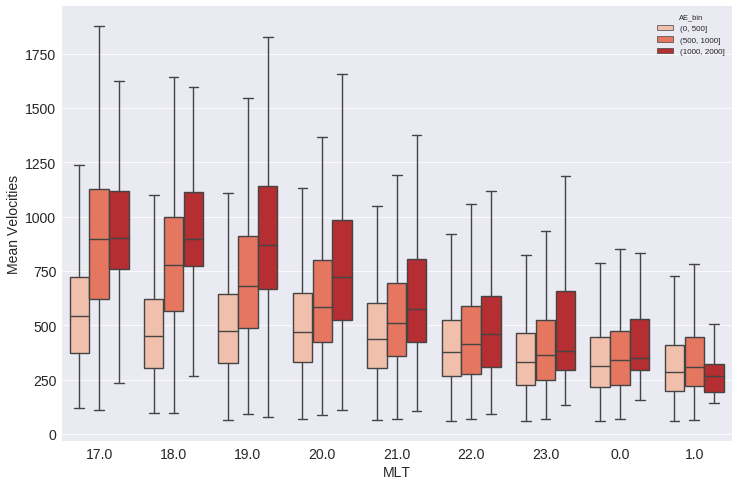

In [17]:
# We need to plot MLTs (we are using normMLT now)
# 
unqNrmMLTList = sorted( velsDataDF[ (velsDataDF["normMLT"] < 2.) ]["normMLT"].unique().tolist() )
mltStr = []
for j in unqNrmMLTList:
    if j < 0:
        mltStr.append( str(j + 24) )
    else:
        mltStr.append( str(j) )

f = plt.figure(figsize=(12, 8))
ax1 = f.add_subplot(1,1,1)
ae_order = [ '(0, 500]', '(500, 1000]', '(1000, 2000]' ]
sns.boxplot( x="normMLT", y="vSaps", hue="AE_bin", data=velsDataDF[ (velsDataDF["normMLT"] < 2.) ],\
            hue_order=ae_order, palette="Reds", showfliers=False )

# plt.xticks( range(len(unqNrmMLTList)), mltStr )
ax1.set_xticklabels( mltStr )
ax1.tick_params(labelsize=14)
ax1.set_xlabel("MLT", fontsize=14)
ax1.set_ylabel("Mean Velocities", fontsize=14)
plt.savefig("../figs/AE-MLT-Vels.pdf",bbox_inches='tight')

In [18]:
mltVelsVarsDF = velsDataDF[ ["normMLT", "AE_bin", "vSaps"] \
                    ].groupby( ["normMLT", "AE_bin"] ).mean().reset_index()
mltVelsVarsDF.columns = ["normMLT", "AE_bin", "mean_vel"]
stdVelsVarsDF = velsDataDF[ ["normMLT", "AE_bin", "vSaps"] \
                    ].groupby( ["normMLT", "AE_bin"] ).std().reset_index()
stdVelsVarsDF.columns = ["normMLT", "AE_bin", "std_vel"]
mltVelsVarsDF = pandas.merge( mltVelsVarsDF, stdVelsVarsDF, on=["normMLT", "AE_bin"] )

In [19]:
# Fit a straight line to each of the dst bins
def linear_func(x, slope, intrcpt):
    # we are working in degrees but numpy deals with radians
    # convert to radians
    return intrcpt + slope*x

fitDFAe500 = mltVelsVarsDF[ mltVelsVarsDF[ "AE_bin" ] == "(0, 500]" ].dropna()
fitDFAe1000 = mltVelsVarsDF[ mltVelsVarsDF[ "AE_bin" ] == "(500, 1000]" ].dropna()
fitDFAe2000 = mltVelsVarsDF[ mltVelsVarsDF[ "AE_bin" ] == "(1000, 2000]" ].dropna()
slope500, intercept500, r_value500,\
    p_value500, std_err500 = linregress(\
                fitDFAe500['normMLT'].T,fitDFAe500['mean_vel'].T )
popt500 = []
popt500.append( slope500 )
popt500.append( intercept500 )

print "AE 500-->", slope500, intercept500, r_value500, p_value500, std_err500

slope1000, intercept1000, r_value1000,\
    p_value1000, std_err1000 = linregress(\
                fitDFAe1000['normMLT'].T,fitDFAe1000['mean_vel'].T )
popt1000 = []
popt1000.append( slope1000 )
popt1000.append( intercept1000 )

print "AE 1000-->", slope1000, intercept1000, r_value1000, p_value1000, std_err1000


slope2000, intercept2000, r_value2000,\
    p_value2000, std_err2000 = linregress(\
                fitDFAe2000['normMLT'].T,fitDFAe2000['mean_vel'].T )
popt2000 = []
popt2000.append( slope2000 )
popt2000.append( intercept2000 )


print "AE 2000-->", slope2000, intercept2000, r_value2000, p_value2000, std_err2000


# Now get data from the fits
normMLTModel500 = range( int( numpy.min(fitDFAe500['normMLT']) ), int( numpy.max(fitDFAe500['normMLT']) ) + 1, 1)
velArrModel500 = [ round( linear_func(t, popt500[0], popt500[1]) ) for t in normMLTModel500 ]

normMLTModel1000 = range( int( numpy.min(fitDFAe1000['normMLT']) ), int( numpy.max(fitDFAe1000['normMLT']) ) + 1, 1)
velArrModel1000 = [ round( linear_func(t, popt1000[0], popt1000[1]) ) for t in normMLTModel1000 ]

normMLTModel2000 = range( int( numpy.min(fitDFAe2000['normMLT']) ), int( numpy.max(fitDFAe2000['normMLT']) ) + 1, 1)
velArrModel2000 = [ round( linear_func(t, popt2000[0], popt2000[1]) ) for t in normMLTModel2000 ]



AE 500--> -29.5816398176 354.401378457 -0.971383213806 6.37261573575e-07 2.41105075247
AE 1000--> -63.077213539 401.623593066 -0.976608820294 1.27333778089e-06 4.91013340059
AE 2000--> -86.3984479505 414.127253277 -0.9879327651 9.14337000799e-08 4.78892777884


In [20]:
strVel500 = "Vel = " + str( int(round( popt500[1] ) ) ) + " + (" + str( int( round( popt500[0] ) ) )  + ") x $\Delta MLT_{00}$"
strVel1000 = "Vel = " + str( int( round( popt1000[1] ) ) ) + " + (" + str( int( round( popt1000[0] ) ) )  + ") x $\Delta MLT_{00}$"
strVel2000 = "Vel = " + str( int( round( popt2000[1] ) ) ) + " + (" + str( int( round( popt2000[0] ) ) )  + ") x $\Delta MLT_{00}$"


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  after removing the cwd from sys.path.


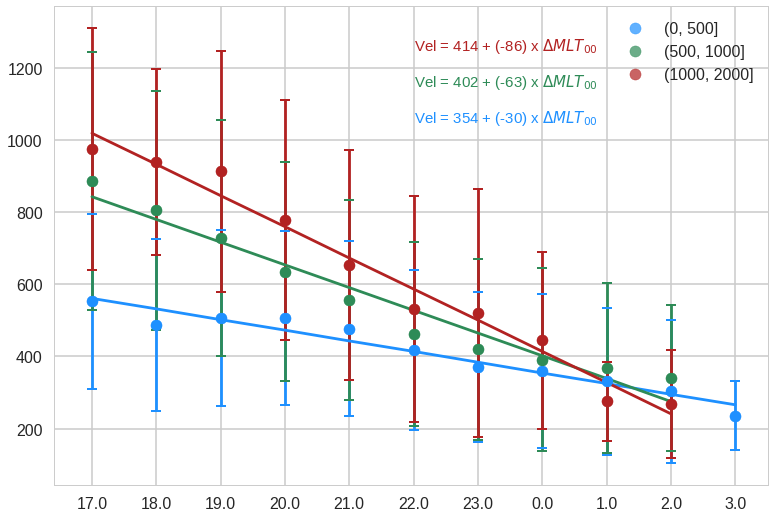

In [21]:
sns.set_style("whitegrid")
sns.set_context("poster")

mltVelsVarsDF = mltVelsVarsDF.sort(["normMLT"])
unqNrmMLTList = sorted( mltVelsVarsDF["normMLT"].unique().tolist() )
mltStr = []
for j in unqNrmMLTList:
    if j < 0:
        mltStr.append( str(j + 24) )
    else:
        mltStr.append( str(j) )
        

###### PLOT AE-bin (0, 500] ######
###### PLOT AE-bin (0, 500] ######
###### PLOT AE-bin (0, 500] ######

plt.scatter(mltVelsVarsDF['normMLT'][mltVelsVarsDF['AE_bin'] == "(0, 500]"],
            mltVelsVarsDF['mean_vel'][mltVelsVarsDF['AE_bin'] == "(0, 500]"],
            marker='o',
            color='dodgerblue',
            alpha=0.7,
            s = 124,
            label='(0, 500]')
plt.errorbar(mltVelsVarsDF['normMLT'][mltVelsVarsDF['AE_bin'] == "(0, 500]"],\
             mltVelsVarsDF['mean_vel'][mltVelsVarsDF['AE_bin'] == "(0, 500]"],\
             yerr=mltVelsVarsDF['std_vel'][mltVelsVarsDF['AE_bin'] == "(0, 500]"], \
             color='dodgerblue', label='', capthick=2., capsize=5., fmt='o')
plt.plot( normMLTModel500, velArrModel500, color='dodgerblue' )

plt.xticks(unqNrmMLTList, mltStr, size='small')

###### PLOT AE-bin (0, 500] ######
###### PLOT AE-bin (0, 500] ######
###### PLOT AE-bin (0, 500] ######


###### PLOT AE-bin (500, 1000] ######
###### PLOT AE-bin (500, 1000] ######
###### PLOT AE-bin (500, 1000] ######

plt.scatter(mltVelsVarsDF['normMLT'][mltVelsVarsDF['AE_bin'] == "(500, 1000]"],
            mltVelsVarsDF['mean_vel'][mltVelsVarsDF['AE_bin'] == "(500, 1000]"],
            marker='o',
            color='seagreen',
            alpha=0.7,
            s = 124,
            label='(500, 1000]')
plt.errorbar(mltVelsVarsDF['normMLT'][mltVelsVarsDF['AE_bin'] == "(500, 1000]"],\
             mltVelsVarsDF['mean_vel'][mltVelsVarsDF['AE_bin'] == "(500, 1000]"],\
             yerr=mltVelsVarsDF['std_vel'][mltVelsVarsDF['AE_bin'] == "(500, 1000]"], \
             color='seagreen', label='', capthick=2., capsize=5., fmt='o')

plt.plot( normMLTModel1000, velArrModel1000, color='seagreen' )

plt.xticks(unqNrmMLTList, mltStr, size='small')

###### PLOT AE-bin (500, 1000] ######
###### PLOT AE-bin (500, 1000] ######
###### PLOT AE-bin (500, 1000] ######


###### PLOT AE-bin (1000, 2100] ######
###### PLOT AE-bin (1000, 2100] ######
###### PLOT AE-bin (1000, 2100] ######

plt.scatter(mltVelsVarsDF['normMLT'][mltVelsVarsDF['AE_bin'] == "(1000, 2000]"],
            mltVelsVarsDF['mean_vel'][mltVelsVarsDF['AE_bin'] == "(1000, 2000]"],
            marker='o',
            color='firebrick',
            alpha=0.7,
            s = 124,
            label='(1000, 2000]')
plt.errorbar(mltVelsVarsDF['normMLT'][mltVelsVarsDF['AE_bin'] == "(1000, 2000]"],\
             mltVelsVarsDF['mean_vel'][mltVelsVarsDF['AE_bin'] == "(1000, 2000]"],\
             yerr=mltVelsVarsDF['std_vel'][mltVelsVarsDF['AE_bin'] == "(1000, 2000]"], \
             color='firebrick', label='', capthick=2., capsize=5., fmt='o')

plt.plot( normMLTModel2000, velArrModel2000, color='firebrick' )

plt.xticks(unqNrmMLTList, mltStr, size='small')

###### PLOT AE-bin (1000, 2100] ######
###### PLOT AE-bin (1000, 2100] ######
###### PLOT AE-bin (1000, 2100] ######


plt.text(-2., 1250., strVel2000, fontsize=15, color='firebrick')
plt.text(-2., 1150., strVel1000, fontsize=15, color='seagreen')
plt.text(-2., 1050., strVel500, fontsize=15, color='dodgerblue')

plt.legend()
plt.savefig("../figs/AE-MLT-Vels-meanstd.pdf",bbox_inches='tight')

In [22]:
mltVelsVarsDstDF = velsDataDF[ ["normMLT", "dst_bin", "vSaps"] \
                    ].groupby( ["normMLT", "dst_bin"] ).mean().reset_index()
mltVelsVarsDstDF.columns = ["normMLT", "dst_bin", "mean_vel"]
stdVelsVarDstDF = velsDataDF[ ["normMLT", "dst_bin", "vSaps"] \
                    ].groupby( ["normMLT", "dst_bin"] ).std().reset_index()
stdVelsVarDstDF.columns = ["normMLT", "dst_bin", "std_vel"]
mltVelsVarsDstDF = pandas.merge( mltVelsVarsDstDF, stdVelsVarDstDF, on=["normMLT", "dst_bin"] )

In [23]:
# Fit a straight line to each of the dst bins
def linear_func(x, slope, intrcpt):
    # we are working in degrees but numpy deals with radians
    # convert to radians
    return intrcpt + slope*x

fitDF1010 = mltVelsVarsDstDF[ mltVelsVarsDstDF[ "dst_bin" ] == "(-10, 10]" ]
fitDF2510 = mltVelsVarsDstDF[ mltVelsVarsDstDF[ "dst_bin" ] == "(-25, -10]" ]
fitDF5025 = mltVelsVarsDstDF[ mltVelsVarsDstDF[ "dst_bin" ] == "(-50, -25]" ]
fitDF7550 = mltVelsVarsDstDF[ mltVelsVarsDstDF[ "dst_bin" ] == "(-75, -50]" ]
fitDF15075 = mltVelsVarsDstDF[ mltVelsVarsDstDF[ "dst_bin" ] == "(-150, -75]" ]

slope1010, intercept1010, r_value1010,\
    p_value1010, std_err1010 = linregress(\
                fitDF1010['normMLT'].T,fitDF1010['mean_vel'].T )
popt1010 = []
popt1010.append( slope1010 )
popt1010.append( intercept1010 )

print "Dst 1010-->", slope1010, intercept1010, r_value1010, p_value1010, std_err1010

slope2510, intercept2510, r_value2510,\
    p_value2510, std_err2510 = linregress(\
                fitDF2510['normMLT'].T,fitDF2510['mean_vel'].T )
popt2510 = []
popt2510.append( slope2510 )
popt2510.append( intercept2510 )

print "Dst 2510-->", slope2510, intercept2510, r_value2510, p_value2510, std_err2510


slope5025, intercept5025, r_value5025,\
    p_value5025, std_err5025 = linregress(\
                fitDF5025['normMLT'].T,fitDF5025['mean_vel'].T )
popt5025 = []
popt5025.append( slope5025 )
popt5025.append( intercept5025 )


print "Dst 5025-->", slope5025, intercept5025, r_value5025, p_value5025, std_err5025



slope7550, intercept7550, r_value7550,\
    p_value7550, std_err7550 = linregress(\
                fitDF7550['normMLT'].T,fitDF7550['mean_vel'].T )
popt7550 = []
popt7550.append( slope7550 )
popt7550.append( intercept7550 )

print "Dst 7550-->", slope7550, intercept7550, r_value7550, p_value7550, std_err7550


slope15075, intercept15075, r_value15075,\
    p_value15075, std_err15075 = linregress(\
                fitDF15075['normMLT'].T,fitDF15075['mean_vel'].T )
popt15075 = []
popt15075.append( slope15075 )
popt15075.append( intercept15075 )

print "Dst 15075-->", slope15075, intercept15075, r_value15075, p_value15075, std_err15075

# Now get data from the fits
normMLTModel1010 = range( int( numpy.min(fitDF1010['normMLT']) ), int( numpy.max(fitDF1010['normMLT']) ) + 1, 1)
velArrModel1010 = [ round( linear_func(t, popt1010[0], popt1010[1]) ) for t in normMLTModel1010 ]

normMLTModel2510 = range( int( numpy.min(fitDF2510['normMLT']) ), int( numpy.max(fitDF2510['normMLT']) ) + 1, 1)
velArrModel2510 = [ round( linear_func(t, popt2510[0], popt2510[1]) ) for t in normMLTModel2510 ]

normMLTModel5025 = range( int( numpy.min(fitDF5025['normMLT']) ), int( numpy.max(fitDF5025['normMLT']) ) + 1, 1)
velArrModel5025 = [ round( linear_func(t, popt5025[0], popt5025[1]) ) for t in normMLTModel5025 ]

normMLTModel7550 = range( int( numpy.min(fitDF7550['normMLT']) ), int( numpy.max(fitDF7550['normMLT']) ) + 1, 1)
velArrModel7550 = [ round( linear_func(t, popt7550[0], popt7550[1]) ) for t in normMLTModel7550 ]

normMLTModel15075 = range( int( numpy.min(fitDF15075['normMLT']) ), int( numpy.max(fitDF15075['normMLT']) ) + 1, 1)
velArrModel15075 = [ round( linear_func(t, popt15075[0], popt15075[1]) ) for t in normMLTModel15075 ]

Dst 1010--> -48.1628480002 389.506071108 -0.98730925456 3.46108814871e-05 3.46457720665
Dst 2510--> -45.8765710744 359.590117435 -0.951639681438 0.000962346541661 6.62335146826
Dst 5025--> -42.3438089237 368.367340518 -0.976684175701 6.2291492445e-06 3.51787804552
Dst 7550--> -45.4646196842 417.74973156 -0.976859275985 1.22004132754e-06 3.51943471145
Dst 15075--> -54.0725427672 489.659159178 -0.980638658475 1.78820990709e-05 4.4082123438


In [24]:
# get the linear equations for the fitted velocities as string to note them on plots.
# prev sym for mlt norm--> $MLT_{Norm}$
# Now we use $\Delta MLT_{00}$
strVel15075 = "Vel = " + str( int(round( popt15075[1] ) ) ) + " + (" + str( int( round( popt15075[0] ) ) )  + ") x $\Delta MLT_{00}$"
strVel7550 = "Vel = " + str( int( round( popt7550[1] ) ) ) + " + (" + str( int( round( popt7550[0] ) ) )  + ") x $\Delta MLT_{00}$"
strVel5025 = "Vel = " + str( int( round( popt5025[1] ) ) ) + " + (" + str( int( round( popt5025[0] ) ) )  + ") x $\Delta MLT_{00}$"
strVel2510 = "Vel = " + str( int( round( popt2510[1] ) ) ) + " + (" + str( int( round( popt2510[0] ) ) )  + ") x $\Delta MLT_{00}$"
strVel1010 = "Vel = " + str( int( round( popt1010[1] ) ) ) + " + (" + str( int( round( popt1010[0] ) ) )  + ") x $\Delta MLT_{00}$"

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  after removing the cwd from sys.path.


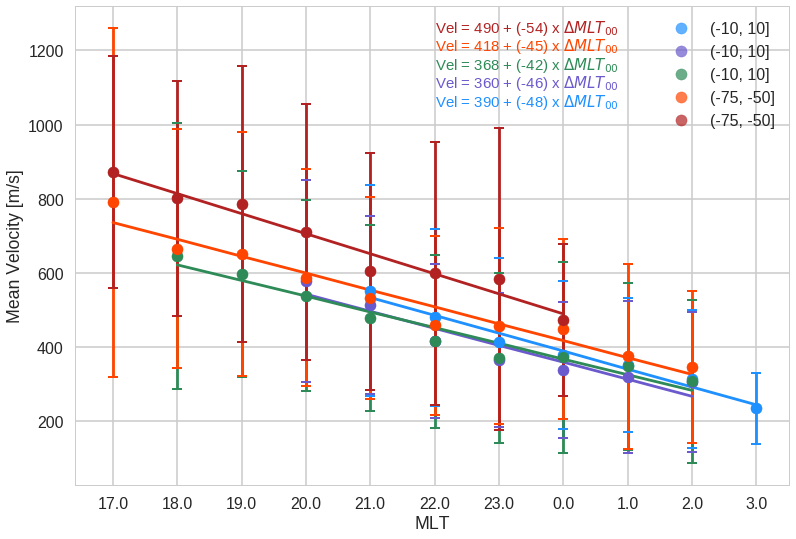

In [25]:
sns.set_style("whitegrid")
sns.set_context("poster")

mltVelsVarsDstDF = mltVelsVarsDstDF.sort(["normMLT"])
unqNrmMLTList = sorted( mltVelsVarsDstDF["normMLT"].unique().tolist() )
mltStr = []
for j in unqNrmMLTList:
    if j < 0:
        mltStr.append( str(j + 24) )
    else:
        mltStr.append( str(j) )
###### PLOT AE-bin (-10, 10] ######
###### PLOT AE-bin (-10, 10] ######
###### PLOT AE-bin (-10, 10] ######

plt.scatter(mltVelsVarsDstDF['normMLT'][mltVelsVarsDstDF['dst_bin'] == "(-10, 10]"],
            mltVelsVarsDstDF['mean_vel'][mltVelsVarsDstDF['dst_bin'] == "(-10, 10]"],
            marker='o',
            color='dodgerblue',
            alpha=0.7,
            s = 124,
            label='(-10, 10]')
plt.errorbar(mltVelsVarsDstDF['normMLT'][mltVelsVarsDstDF['dst_bin'] == "(-10, 10]"],\
             mltVelsVarsDstDF['mean_vel'][mltVelsVarsDstDF['dst_bin'] == "(-10, 10]"],\
             yerr=mltVelsVarsDstDF['std_vel'][mltVelsVarsDstDF['dst_bin'] == "(-10, 10]"], \
             color='dodgerblue', label='', capthick=2., capsize=5., fmt='o')

plt.plot( normMLTModel1010, velArrModel1010, color='dodgerblue' )

plt.xticks(unqNrmMLTList, mltStr, size='small')

###### PLOT AE-bin (-10, 10] ######
###### PLOT AE-bin (-10, 10] ######
###### PLOT AE-bin (-10, 10] ######


###### PLOT AE-bin (-25, -10] ######
###### PLOT AE-bin (-25, -10] ######
###### PLOT AE-bin (-25, -10] ######

plt.scatter(mltVelsVarsDstDF['normMLT'][mltVelsVarsDstDF['dst_bin'] == "(-25, -10]"],
            mltVelsVarsDstDF['mean_vel'][mltVelsVarsDstDF['dst_bin'] == "(-25, -10]"],
            marker='o',
            color='slateblue',
            alpha=0.7,
            s = 124,
            label='(-10, 10]')
plt.errorbar(mltVelsVarsDstDF['normMLT'][mltVelsVarsDstDF['dst_bin'] == "(-25, -10]"],\
             mltVelsVarsDstDF['mean_vel'][mltVelsVarsDstDF['dst_bin'] == "(-25, -10]"],\
             yerr=mltVelsVarsDstDF['std_vel'][mltVelsVarsDstDF['dst_bin'] == "(-25, -10]"], \
             color='slateblue', label='', capthick=2., capsize=5., fmt='o')

plt.plot( normMLTModel2510, velArrModel2510, color='slateblue' )


plt.xticks(unqNrmMLTList, mltStr, size='small')

###### PLOT AE-bin (-25, -10] ######
###### PLOT AE-bin (-25, -10] ######
###### PLOT AE-bin (-25, -10] ######


###### PLOT AE-bin (1000, 2100] ######
###### PLOT AE-bin (1000, 2100] ######
###### PLOT AE-bin (1000, 2100] ######

plt.scatter(mltVelsVarsDstDF['normMLT'][mltVelsVarsDstDF['dst_bin'] == "(-50, -25]"],
            mltVelsVarsDstDF['mean_vel'][mltVelsVarsDstDF['dst_bin'] == "(-50, -25]"],
            marker='o',
            color='seagreen',
            alpha=0.7,
            s = 124,
            label='(-10, 10]')
plt.errorbar(mltVelsVarsDstDF['normMLT'][mltVelsVarsDstDF['dst_bin'] == "(-50, -25]"],\
             mltVelsVarsDstDF['mean_vel'][mltVelsVarsDstDF['dst_bin'] == "(-50, -25]"],\
             yerr=mltVelsVarsDstDF['std_vel'][mltVelsVarsDstDF['dst_bin'] == "(-50, -25]"], \
             color='seagreen', label='', capthick=2., capsize=5., fmt='o')

plt.plot( normMLTModel5025, velArrModel5025, color='seagreen' )

plt.xticks(unqNrmMLTList, mltStr, size='small')

###### PLOT AE-bin (1000, 2100] ######
###### PLOT AE-bin (1000, 2100] ######
###### PLOT AE-bin (1000, 2100] ######


###### PLOT AE-bin (-75, -50] ######
###### PLOT AE-bin (-75, -50] ######
###### PLOT AE-bin (-75, -50] ######

plt.scatter(mltVelsVarsDstDF['normMLT'][mltVelsVarsDstDF['dst_bin'] == "(-75, -50]"],
            mltVelsVarsDstDF['mean_vel'][mltVelsVarsDstDF['dst_bin'] == "(-75, -50]"],
            marker='o',
            color='orangered',
            alpha=0.7,
            s = 124,
            label='(-75, -50]')
plt.errorbar(mltVelsVarsDstDF['normMLT'][mltVelsVarsDstDF['dst_bin'] == "(-75, -50]"],\
             mltVelsVarsDstDF['mean_vel'][mltVelsVarsDstDF['dst_bin'] == "(-75, -50]"],\
             yerr=mltVelsVarsDstDF['std_vel'][mltVelsVarsDstDF['dst_bin'] == "(-75, -50]"], \
             color='orangered', label='', capthick=2., capsize=5., fmt='o')
plt.plot( normMLTModel7550, velArrModel7550, color='orangered' )


plt.xticks(unqNrmMLTList, mltStr, size='small')

###### PLOT AE-bin (-75, -50] ######
###### PLOT AE-bin (-75, -50] ######
###### PLOT AE-bin (-75, -50] ######


###### PLOT AE-bin (-150, -75] ######
###### PLOT AE-bin (-150, -75] ######
###### PLOT AE-bin (-150, -75] ######

plt.scatter(mltVelsVarsDstDF['normMLT'][mltVelsVarsDstDF['dst_bin'] == "(-150, -75]"],
            mltVelsVarsDstDF['mean_vel'][mltVelsVarsDstDF['dst_bin'] == "(-150, -75]"],
            marker='o',
            color='firebrick',
            alpha=0.7,
            s = 124,
            label='(-75, -50]')
plt.errorbar(mltVelsVarsDstDF['normMLT'][mltVelsVarsDstDF['dst_bin'] == "(-150, -75]"],\
             mltVelsVarsDstDF['mean_vel'][mltVelsVarsDstDF['dst_bin'] == "(-150, -75]"],\
             yerr=mltVelsVarsDstDF['std_vel'][mltVelsVarsDstDF['dst_bin'] == "(-150, -75]"], \
             color='firebrick', label='', capthick=2., capsize=5., fmt='o')

plt.plot( normMLTModel15075, velArrModel15075, color='firebrick' )

plt.xticks(unqNrmMLTList, mltStr, size='small')

###### PLOT AE-bin (-150, -75] ######
###### PLOT AE-bin (-150, -75] ######
###### PLOT AE-bin (-150, -75] ######

plt.text(-2., 1250., strVel15075, fontsize=15, color='firebrick')
plt.text(-2., 1200., strVel7550, fontsize=15, color='orangered')
plt.text(-2., 1150., strVel5025, fontsize=15, color='seagreen')
plt.text(-2., 1100., strVel2510, fontsize=15, color='slateblue')
plt.text(-2., 1050., strVel1010, fontsize=15, color='dodgerblue')

plt.savefig("../figs/Dst-MLT-Vels-meanstd.pdf",bbox_inches='tight')

plt.xlabel("MLT")
plt.ylabel("Mean Velocity [m/s]")
plt.legend()
plt.savefig("../figs/Dst-MLT-Vels-meanstd.pdf",bbox_inches='tight')

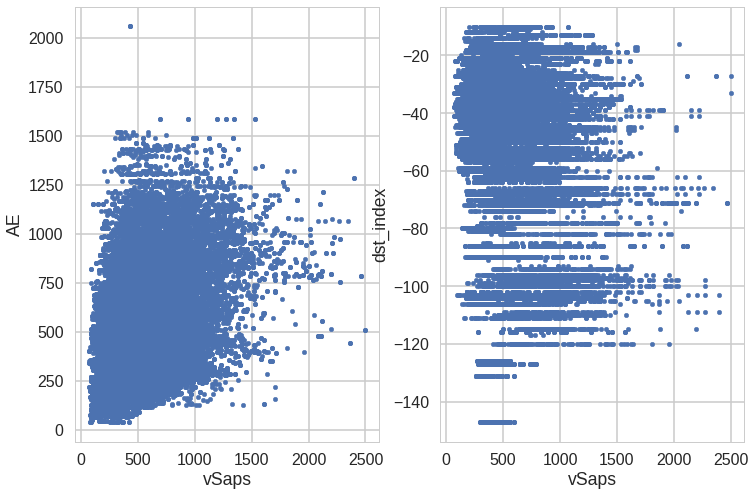

In [26]:
f = plt.figure(figsize=(12, 8))
ax1 = f.add_subplot(1,2,1)
ax2 = f.add_subplot(1,2,2)

selMltDF = velsDataDF[ velsDataDF["normMLT"] == -4 ][ ["normMLT", "AE", "dst_index", "vSaps"] ]
selMltDF.plot( kind="scatter", x="vSaps", y="AE", ax=ax1 )
selMltDF.plot( kind="scatter", x="vSaps", y="dst_index", ax=ax2 )

In [27]:
highspeedDF = velsDataDF[ (velsDataDF["vSaps"] > 1500.) & (velsDataDF["AE"] > 1000.) ][\
                [ "date", "vSaps", "azim", "azimStd", "dst_bin", "AE" ] ]
dates = highspeedDF.groupby( "date" ).size()
